# Read Database
read database from "./Mall_Customers.csv" and make simple check.

In [88]:
import pandas
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

data_path = "./Mall_Customers.csv"

df = pandas.read_csv(data_path)

print(df.head())

RANDOM_SEED = 42

   CustomerID   Genre  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40


In [89]:
genre = df['Genre']
for g in genre.unique():
	if g != 'Male' and g != 'Female' :
		print(f"Unknown genre found: {g}")

age = df['Age']
if age.isnull().any():
	print("Missing values found in Age column")

income = df['Annual Income (k$)']
if (income < 0).any():
	print("Negative values found in Annual Income column")

spending_score = df['Spending Score (1-100)']
if (spending_score < 1).any() or (spending_score > 100).any():
	print("Out of range values found in Spending Score column")

customer_ids = df['CustomerID'].unique()
if len(customer_ids) != len(df):
	print("Duplicate CustomerID values found")

# no ouput means all checks passed

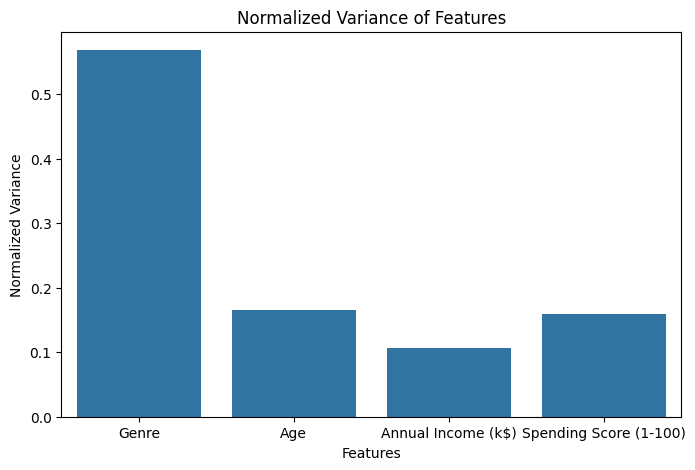

In [90]:
# treat genre as binary variables

# set 'genre' as 'Male'->0, 'Female'->distance
df['Genre'] = df['Genre'].apply(lambda x: 0 if x == 'Male' else 1)

# calculate normalized variance for each column and reduce features with low variance
numeric_cols = ['Genre', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)']
# use PCA to analysis variance
pca = PCA()
features = df[numeric_cols].values

pca.fit((features - np.min(features, axis=0)) / (np.max(features, axis=0) - np.min(features, axis=0)))
normalized_variances = pca.explained_variance_ratio_

contribute = np.sum((pca.components_)**2 * normalized_variances[:, np.newaxis], axis=0)
contribute = pandas.Series(contribute, index=numeric_cols)

# plot it for visualization
plt.figure(figsize=(8, 5))
sns.barplot(x=contribute.index, y=contribute.values)
plt.title('Normalized Variance of Features')
plt.ylabel('Normalized Variance')
plt.xlabel('Features')
plt.show()


Thus genre can be reduced.

In [91]:
df_reduced = df.copy()
low_variance_threshold = 0.05
for col, norm_var in contribute.items():
	if norm_var < low_variance_threshold:
		print(f"Dropping column {col} with normalized variance {norm_var}")
		df_reduced = df_reduced.drop(columns=[col])
print("Reduced DataFrame columns:", df_reduced.columns.tolist())

print(df_reduced.head())

features = df_reduced.drop(columns=['CustomerID']).to_numpy()

Reduced DataFrame columns: ['CustomerID', 'Genre', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)']
   CustomerID  Genre  Age  Annual Income (k$)  Spending Score (1-100)
0           1      0   19                  15                      39
1           2      0   21                  15                      81
2           3      1   20                  16                       6
3           4      1   23                  16                      77
4           5      1   31                  17                      40


# Clustering With KMeans

Use KMeans clustering algorithm to cluster the customers based on all features except CustomerID.

Sort clustered points by cluster label and visualize the similar matrix.

Then Determine optimal number of clusters using SSE curve.

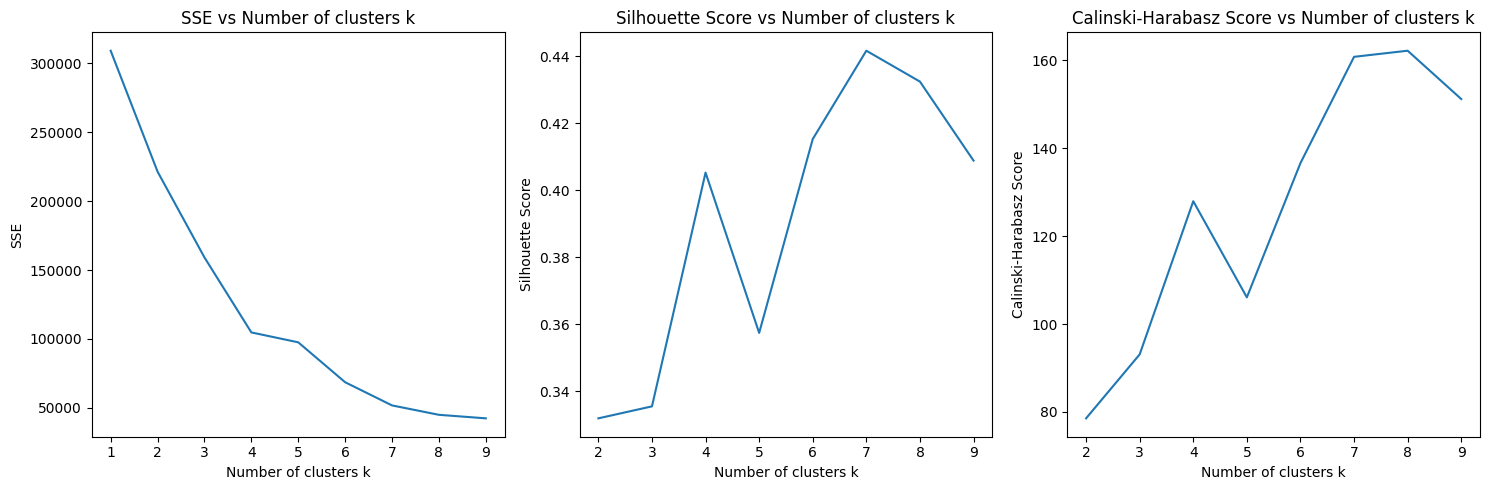

Optimal number of clusters: 7
Optimal silhouette score: 0.44172063782131477


In [92]:
def sse(points, labels, max_k) :
	centroids : list[np.ndarray] = []
	for k in range(0, max_k) :
		mask = labels == k
		cluster_points = points[mask]
		centroid = np.mean(cluster_points, axis=0)
		centroids.append(centroid)
	
	sse = 0.0
	centroids_arr = np.zeros_like(points)
	for i in range(len(points)) :
		centroids_arr[i] = centroids[labels[i]]
	sse = np.sum((points - centroids_arr) ** 2)
	return sse


sse_hist = []
sil_hist = []
cal_hist = []
for max_k in range(1, 10) :
	kmeans = KMeans(n_clusters=max_k, random_state=RANDOM_SEED, max_iter=1000)
	kmeans.fit(features)
	labels_kmeans = kmeans.labels_
	sse_value = sse(features, labels_kmeans, max_k)
	sse_hist.append(sse_value)
	if max_k > 1 :
		sil_value = silhouette_score(features, labels_kmeans)
		sil_hist.append(sil_value)
		cal_value = calinski_harabasz_score(features, labels_kmeans)
		cal_hist.append(cal_value)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(range(1, 10), sse_hist)
plt.xlabel("Number of clusters k")
plt.ylabel("SSE")
plt.title("SSE vs Number of clusters k")

plt.subplot(1, 3, 2)
plt.plot(range(2, 10), sil_hist)
plt.xlabel("Number of clusters k")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs Number of clusters k")

plt.subplot(1, 3, 3)
plt.plot(range(2, 10), cal_hist)
plt.xlabel("Number of clusters k")
plt.ylabel("Calinski-Harabasz Score")
plt.title("Calinski-Harabasz Score vs Number of clusters k")
plt.tight_layout()
plt.show()

sil_hist = np.array(sil_hist)
opt_k = np.argmax(sil_hist) + 2  # +2 because sil_hist starts from k=2
print(f"Optimal number of clusters: {opt_k}")
opt_sil = sil_hist[opt_k - 2]
print(f"Optimal silhouette score: {opt_sil}")

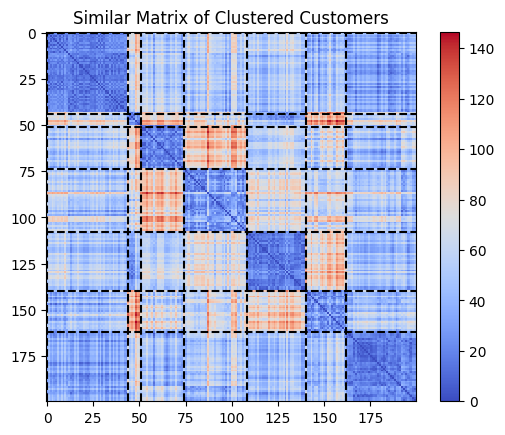

In [93]:
# cluster with optimal k
kmeans = KMeans(n_clusters=opt_k, random_state=RANDOM_SEED, max_iter=1000)
kmeans.fit(features)
labels_kmeans = kmeans.labels_

sorted_indices = np.argsort(labels_kmeans)
sorted_labels = labels_kmeans[sorted_indices]

def get_range(labels, k) :
	indices = np.where(labels == k)[0]
	if len(indices) == 0 :
		return None
	return (indices[0], indices[-1])
sep_indices = [get_range(sorted_labels, k) for k in range(opt_k)]
sorted_features = features[sorted_indices]

# visualize similar matrix
similar_matrix = np.zeros((len(df), len(df)))
for i in range(len(df)) :
	similar_matrix[i, :] = np.linalg.norm(sorted_features - sorted_features[i], axis=1)

plt.imshow(similar_matrix, cmap='coolwarm', interpolation='nearest')
# draw lines to separate clusters
for i in range(0, opt_k) :
	plt.axhline(y=sep_indices[i][0], color='black', linestyle='--')
	plt.axvline(x=sep_indices[i][0], color='black', linestyle='--')
plt.colorbar()
plt.title("Similar Matrix of Clustered Customers")
plt.show()

The similar matrix implies that items in the same cluster are more similar to each other, while items in different clusters are less similar.

# Clustering With DBSCAN

Do similar things with DBSCAN clustering algorithm.

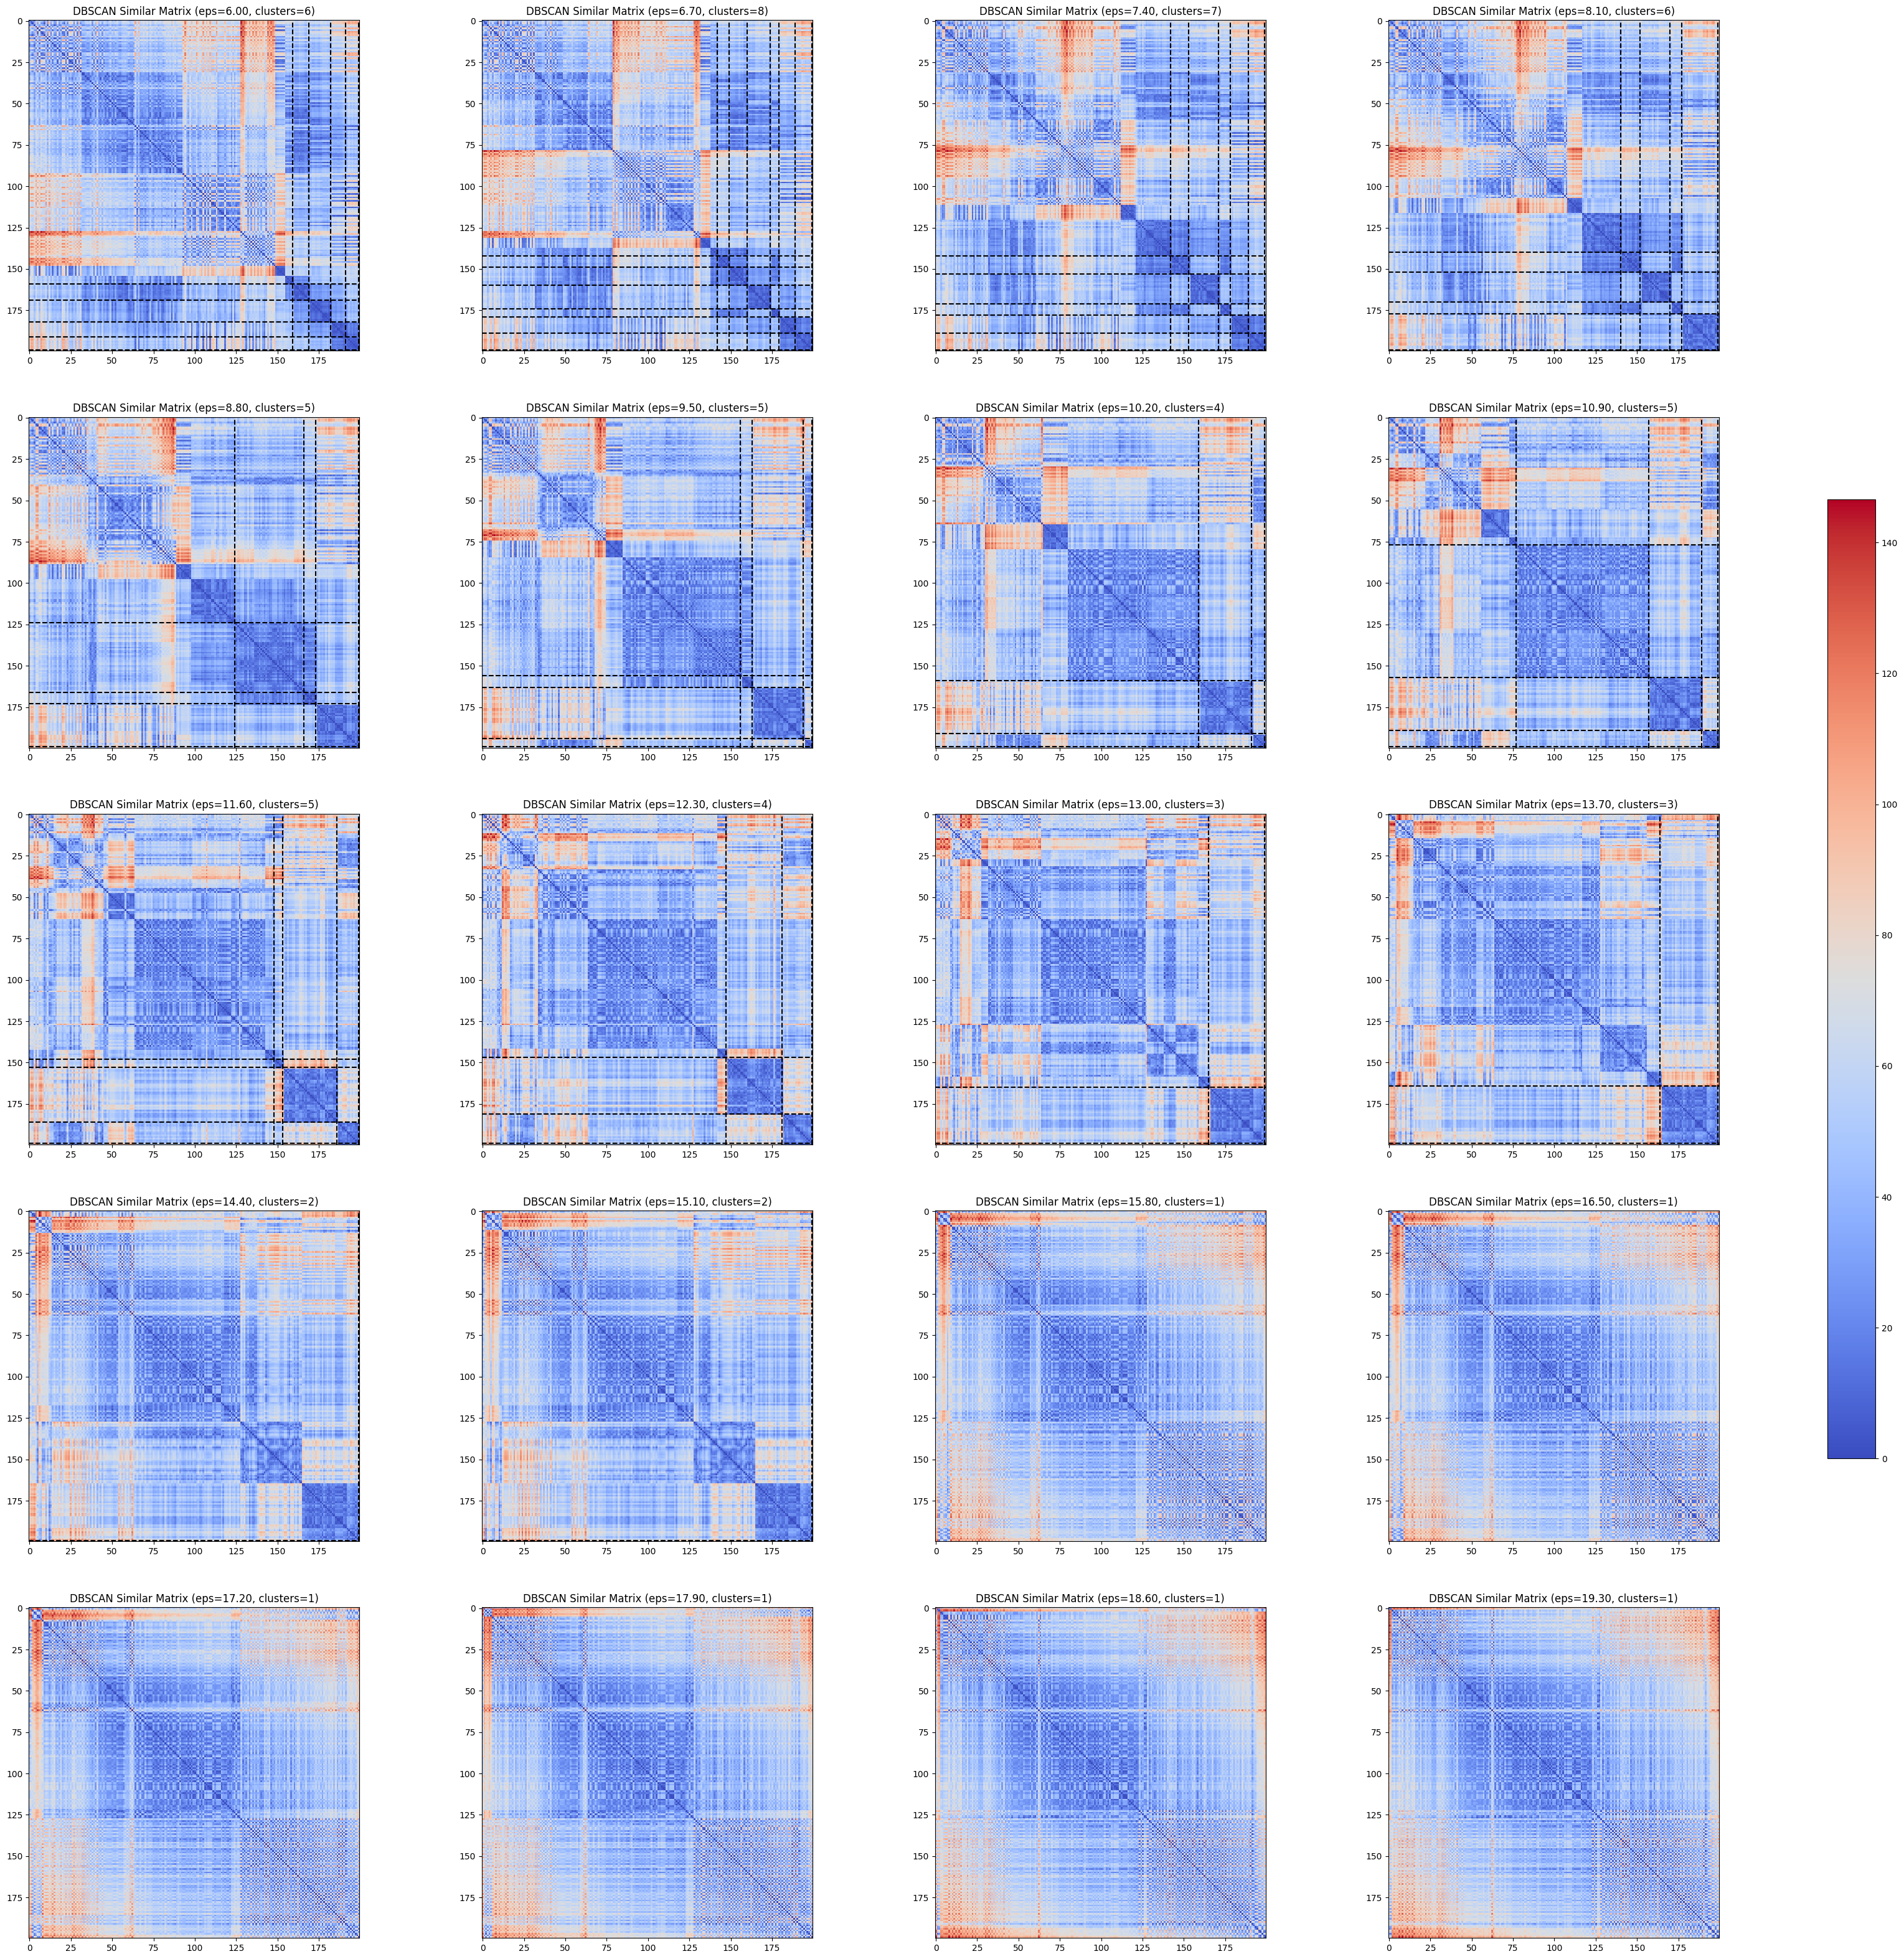

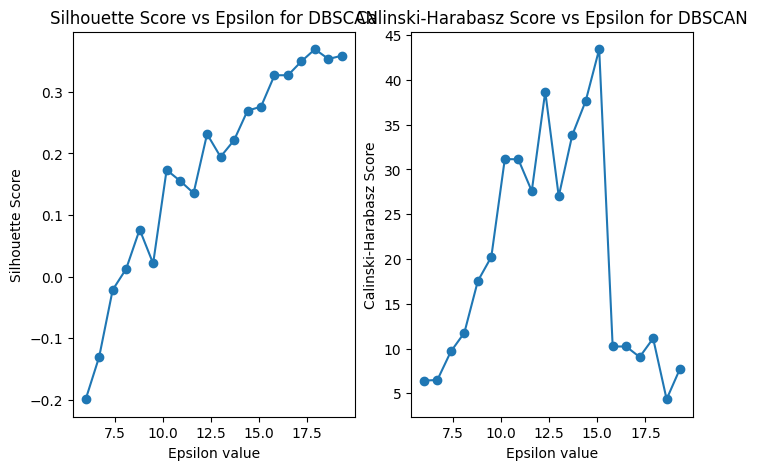

In [94]:
sse_hist_dbscan = []
n_row = 5
n_col = 4

num_attempts = n_row * n_col
similar_matrices_dbscan : list[np.ndarray] = []
cluster_num : list[int] = []
sep_indices_dbscan = []
sil_hist_dbscan = []
cal_hist_dbscan = []

for eps in np.arange(6.0, 20.0, (20.0 - 6.0) / num_attempts) :
	dbscan = DBSCAN(eps=eps, min_samples=5)
	dbscan.fit(features)
	labels_dbscan = dbscan.labels_
	# ignore noise points
	unique_labels = set(labels_dbscan)
	unique_labels.discard(-1)
	num_clusters = len(unique_labels)
	if num_clusters == 0 :
		continue
	sse_value = sse(features, labels_dbscan, num_clusters)
	sse_hist_dbscan.append((eps, sse_value))

	sorted_indices = np.argsort(labels_dbscan)
	sorted_labels = labels_dbscan[sorted_indices]
	sorted_features = features[sorted_indices]
	similar_matrix = np.zeros((len(df), len(df)))
	sep_indices_dbscan.append([get_range(sorted_labels, k) for k in range(num_clusters)])
	for i in range(len(df)) :
		similar_matrix[i, :] = np.linalg.norm(sorted_features - sorted_features[i], axis=1)
	similar_matrices_dbscan.append(similar_matrix)
	cluster_num.append(num_clusters)

	sil_hist_value = silhouette_score(features, labels_dbscan)
	sil_hist_dbscan.append((eps, sil_hist_value))
	cal_hist_value = calinski_harabasz_score(features, labels_dbscan)
	cal_hist_dbscan.append((eps, cal_hist_value))
	

# plot similar matrices
fig, axes = plt.subplots(n_row, n_col, figsize=(45, 40))
for i in range(n_row) :
	for j in range(n_col) :
		index = i * n_col + j
		if index >= len(similar_matrices_dbscan) :
			break
		ax = axes[i, j]
		im = ax.imshow(similar_matrices_dbscan[index], cmap='coolwarm', interpolation='nearest')
		# draw separating lines
		for k in range(1, cluster_num[index]) :
			ax.axhline(y=sep_indices_dbscan[index][k][-1], color='black', linestyle='--')
			ax.axvline(x=sep_indices_dbscan[index][k][-1], color='black', linestyle='--')
		ax.set_title(f"DBSCAN Similar Matrix (eps={sse_hist_dbscan[index][0]:.2f}, clusters={cluster_num[index]})")
fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.5)
plt.show()

# plot silhouette scores for DBSCAN
eps_values = [item[0] for item in sil_hist_dbscan]
sil_values = [item[1] for item in sil_hist_dbscan]
cal_values = [item[1] for item in cal_hist_dbscan]

plt.figure(figsize=(8, 5))
plt.subplot(1, 2, 1)
plt.plot(eps_values, sil_values, marker='o')
plt.xlabel("Epsilon value")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs Epsilon for DBSCAN")

plt.subplot(1, 2, 2)
plt.plot(eps_values, cal_values, marker='o')
plt.xlabel("Epsilon value")
plt.ylabel("Calinski-Harabasz Score")
plt.title("Calinski-Harabasz Score vs Epsilon for DBSCAN")
plt.show()

Silhouette score implies that DBSCAN can not provide better clustering results ($0.33 < 0.4$) , thus it is better to use KMeans for this dataset.

# Further Exploration on Parameters of KMeans

Try different parameters of KMeans and visualize the clustering results again.

In [95]:
import numpy as np
import pandas as pd

feature_subsets = [
	["Age", "Annual Income (k$)", "Spending Score (1-100)", "Genre"],  
	["Annual Income (k$)", "Spending Score (1-100)","Genre"],		 
	["Age", "Spending Score (1-100)","Genre"],
	["Age", "Annual Income (k$)", "Spending Score (1-100)"],
	["Age", "Annual Income (k$)" ,"Genre"]						
]

def sort_search_results(df_results : pd.DataFrame, w_sil=0.6, w_ch=0.4):
	if not df_results.empty:
		for col in ["sil", "CH"]:
			if df_results[col].std() == 0:
				df_results[col + "_z"] = 0.0
			else:
				df_results[col + "_z"] = (
					df_results[col] - df_results[col].mean()
				) / df_results[col].std()
		df_results["score"] = (
			w_sil * df_results["sil_z"] +
			w_ch  * df_results["CH_z"]
		)
		df_results = df_results.sort_values("score", ascending=False).reset_index(drop=True)
	return df_results

def grid_search_kmeans(
	X,
	cluster_range=range(2, 11),
	inits=("k-means++", "random"),
	n_init_list=(10, 20),
	feature_subsets=None,
	w_sil=0.6,
	w_ch=0.4,
):
	if isinstance(X, pd.DataFrame):
		X_df = X.copy()
	else:
		X = np.asarray(X)
		X_df = pd.DataFrame(X, columns=[f"f{i}" for i in range(X.shape[1])])

	all_features = list(X_df.columns)

	if feature_subsets is None:
		feature_subsets = [all_features]

	results = []
	for feat_set in feature_subsets:
		if isinstance(feat_set[0], int):
			feat_cols = [all_features[i] for i in feat_set]
		else:
			feat_cols = list(feat_set)
		X_sub = X_df[feat_cols].values

		overall_mean = X_sub.mean(axis=0)
		tss = np.sum((X_sub - overall_mean) ** 2)

		for k in cluster_range:
			for init in inits:
				for n_init in n_init_list:
					model = KMeans(
						n_clusters=k,
						init=init,
						n_init=n_init,
						random_state=42
					)
					labels = model.fit_predict(X_sub)
					sil = silhouette_score(X_sub, labels)
					ch = calinski_harabasz_score(X_sub, labels)
					sse = model.inertia_
					ssb = tss - sse
					results.append({
						"features": tuple(feat_cols),   
						"n_features": len(feat_cols),
						"k": k,
						"init": init,
						"n_init": n_init,
						"sil": sil,
						"CH": ch,
						"SSE": sse,
						"SSB": ssb,
						"TSS": tss,
						'labels': labels
					})


	df_results = pd.DataFrame(results)

	df_results = sort_search_results(df_results, w_sil=w_sil, w_ch=w_ch)
	return df_results

feature_subsets = [
	["Age", "Annual Income (k$)", "Spending Score (1-100)","Genre"],  
	["Annual Income (k$)", "Spending Score (1-100)","Genre"],		 
	["Age", "Spending Score (1-100)","Genre"],
	["Age", "Annual Income (k$)", "Spending Score (1-100)"],
	["Age", "Annual Income (k$)" ,"Genre"]						
]

res_kmeans = grid_search_kmeans(
	df,
	feature_subsets=feature_subsets,
	cluster_range=range(2, 11),
	inits=("k-means++", "random"),
	n_init_list = np.arange(3, 11),
)

res_kmeans.drop(columns=['labels']).head(10)

,features,n_features,k,init,n_init,sil,CH,SSE,SSB,TSS,sil_z,CH_z,score
0,"(Annual Income (k$), Spending Score (1-100), G...",3,5,k-means++,6,0.55345,247.088707,44497.185468,225533.374532,270030.56,2.385127,0.611111,1.675521
1,"(Annual Income (k$), Spending Score (1-100), G...",3,5,k-means++,7,0.55345,247.088707,44497.185468,225533.374532,270030.56,2.385127,0.611111,1.675521
2,"(Annual Income (k$), Spending Score (1-100), G...",3,5,k-means++,8,0.55345,247.088707,44497.185468,225533.374532,270030.56,2.385127,0.611111,1.675521
3,"(Annual Income (k$), Spending Score (1-100), G...",3,5,k-means++,9,0.55345,247.088707,44497.185468,225533.374532,270030.56,2.385127,0.611111,1.675521
4,"(Annual Income (k$), Spending Score (1-100), G...",3,5,k-means++,10,0.55345,247.088707,44497.185468,225533.374532,270030.56,2.385127,0.611111,1.675521
5,"(Annual Income (k$), Spending Score (1-100), G...",3,5,k-means++,3,0.55345,247.088707,44497.185468,225533.374532,270030.56,2.385127,0.611111,1.675521
6,"(Annual Income (k$), Spending Score (1-100), G...",3,5,k-means++,4,0.55345,247.088707,44497.185468,225533.374532,270030.56,2.385127,0.611111,1.675521
7,"(Annual Income (k$), Spending Score (1-100), G...",3,5,k-means++,5,0.55345,247.088707,44497.185468,225533.374532,270030.56,2.385127,0.611111,1.675521
8,"(Annual Income (k$), Spending Score (1-100), G...",3,5,random,7,0.55345,247.088707,44497.185468,225533.374532,270030.56,2.385127,0.611111,1.675521
9,"(Annual Income (k$), Spending Score (1-100), G...",3,5,random,10,0.55345,247.088707,44497.185468,225533.374532,270030.56,2.385127,0.611111,1.675521


# Hirarchical Clustering
Use Hierarchical Clustering algorithm to cluster the customers based on reduced features.

In [96]:
# use grid search to find optimal parameters for hierarchical clustering
def grid_searchg_hira(
		X,
		num_clustering : list[int],
		linkage_methods : list[str],
		metrics : list[str],
		feature_subsets : list[list[str]],
		w_sil=0.6,
		w_ch=0.4
) :
	if isinstance(X, pd.DataFrame):
		X_df = X.copy()
	else:
		X = np.asarray(X)
		X_df = pd.DataFrame(X, columns=[f"f{i}" for i in range(X.shape[1])])

	all_features = list(X_df.columns)

	if feature_subsets is None:
		feature_subsets = [all_features]

	results = []
	for feat_set in feature_subsets:
		if isinstance(feat_set[0], int):
			feat_cols = [all_features[i] for i in feat_set]
		else:
			feat_cols = list(feat_set)

		X_sub = X_df[feat_cols].values
		
		for n in num_clustering :
			for linkage in linkage_methods :
				for metric in metrics :
					
					if linkage == 'ward' and metric != 'euclidean' :
						continue  # skip invalid combinations

					model = AgglomerativeClustering(
						n_clusters=n,
						linkage=linkage,
						metric=metric
					)
					labels = model.fit_predict(X_sub)
					sil = silhouette_score(X_sub, labels)
					ch = calinski_harabasz_score(X_sub, labels)
					results.append({
						"features": tuple(feat_cols),   
						"n_features": len(feat_cols),
						"n_clusters": n,
						"linkage": linkage,
						"metric": metric,
						"sil": sil,
						"CH": ch,
						'labels': labels
					})
	df_results = pd.DataFrame(results)
	df_results = sort_search_results(df_results, w_sil=w_sil, w_ch=w_ch)
	return df_results

res_hira = grid_searchg_hira(
	df,
	num_clustering = list(range(2, 11)),
	linkage_methods = ['ward', 'complete', 'average', 'single'],
	metrics = ['euclidean', 'manhattan', 'cosine'],
	feature_subsets = feature_subsets
)

res_hira.drop(columns=['labels']).head(10)

,features,n_features,n_clusters,linkage,metric,sil,CH,sil_z,CH_z,score
0,"(Age, Spending Score (1-100), Genre)",3,4,average,manhattan,0.479192,301.609979,1.189718,2.291860,1.630575
1,"(Annual Income (k$), Spending Score (1-100), G...",3,5,ward,euclidean,0.552522,242.810594,1.639972,1.593960,1.621568
2,"(Annual Income (k$), Spending Score (1-100), G...",3,5,average,manhattan,0.549875,243.044165,1.623718,1.596732,1.612924
3,"(Annual Income (k$), Spending Score (1-100), G...",3,5,complete,euclidean,0.541495,240.347280,1.572265,1.564723,1.569248
4,"(Annual Income (k$), Spending Score (1-100), G...",3,5,complete,manhattan,0.538107,241.490807,1.551462,1.578295,1.562196
5,"(Annual Income (k$), Spending Score (1-100), G...",3,6,ward,euclidean,0.537536,232.182931,1.547955,1.467819,1.515901
6,"(Annual Income (k$), Spending Score (1-100), G...",3,7,average,euclidean,0.538866,230.748396,1.556122,1.450792,1.513990
7,"(Annual Income (k$), Spending Score (1-100), G...",3,7,average,manhattan,0.530681,234.431903,1.505864,1.494512,1.501323
8,"(Annual Income (k$), Spending Score (1-100), G...",3,6,average,manhattan,0.540841,225.926417,1.568248,1.393559,1.498372
9,"(Annual Income (k$), Spending Score (1-100), G...",3,6,complete,manhattan,0.524752,234.336761,1.469460,1.493383,1.479029


# Visualization with PCA/t-SNE

Visualize the clustering result with dimensional-reduction algorithm PCA and t-SNE respectively.

/tmp/ipykernel_36636/2374132893.py:17: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(scatters[mask, 0], scatters[mask, 1], c=color_map(k), label=f'Cluster {k}')


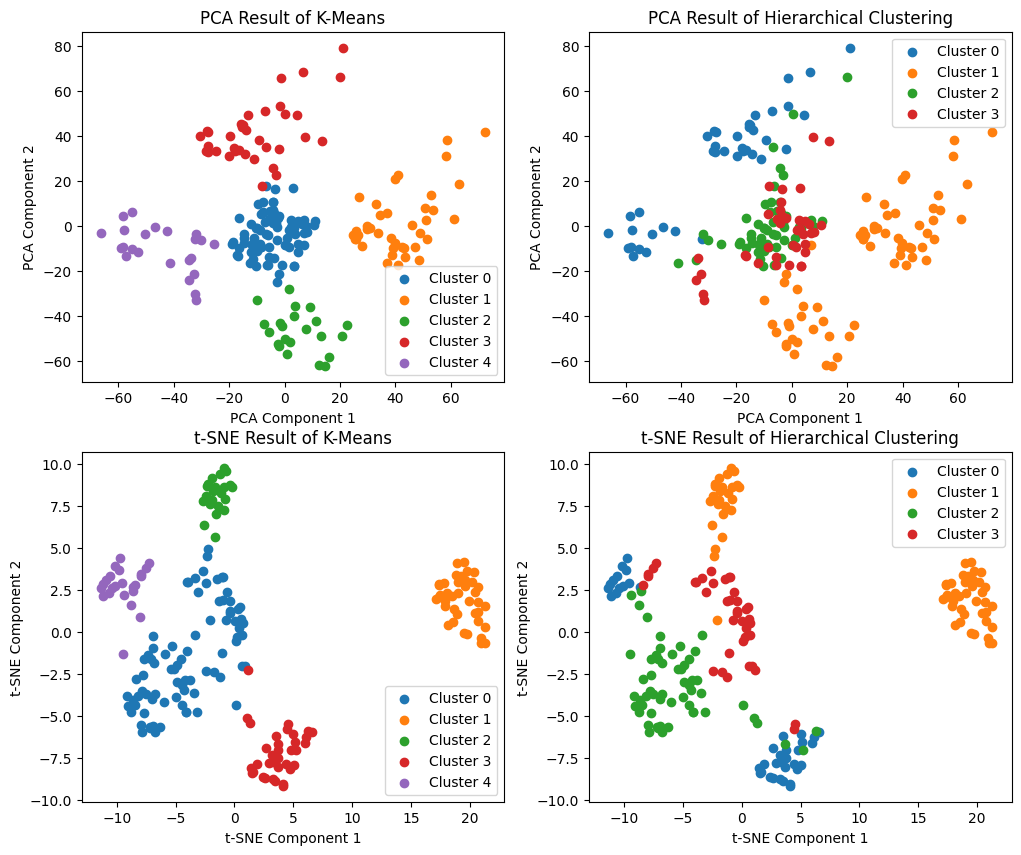

In [97]:
labels_kmeans = res_kmeans.loc[0, 'labels']
labels_hira =  res_hira.loc[0, 'labels']

# with PCA
pca = PCA(n_components=2, random_state=RANDOM_SEED)
pca_result = pca.fit_transform(features)

# with t-SNE
tsne = TSNE(n_components=2, random_state=RANDOM_SEED)
tsne_result = tsne.fit_transform(features)

def plot_clusters(ax : plt.Axes, scatters : np.ndarray, labels : np.ndarray, reduce_name : str, cluster_name : str) :
	num_clusters = len(set(labels))
	color_map = plt.colormaps.get('tab10')
	for k in range(num_clusters) :
		mask = labels == k
		ax.scatter(scatters[mask, 0], scatters[mask, 1], c=color_map(k), label=f'Cluster {k}')
	ax.set_title(f"{reduce_name} Result of {cluster_name}")
	ax.set_xlabel(f"{reduce_name} Component 1")
	ax.set_ylabel(f"{reduce_name} Component 2")
	ax.legend()


fig = plt.figure(figsize=(12, 10))
ax1 = fig.add_subplot(2, 2, 1)
plot_clusters(ax1, pca_result, labels_kmeans, "PCA", "K-Means")
ax2 = fig.add_subplot(2, 2, 2)
plot_clusters(ax2, pca_result, labels_hira, "PCA", "Hierarchical Clustering")
ax3 = fig.add_subplot(2, 2, 3)
plot_clusters(ax3, tsne_result, labels_kmeans, "t-SNE", "K-Means")
ax4 = fig.add_subplot(2, 2, 4)
plot_clusters(ax4, tsne_result, labels_hira, "t-SNE", "Hierarchical Clustering")

plt.show()

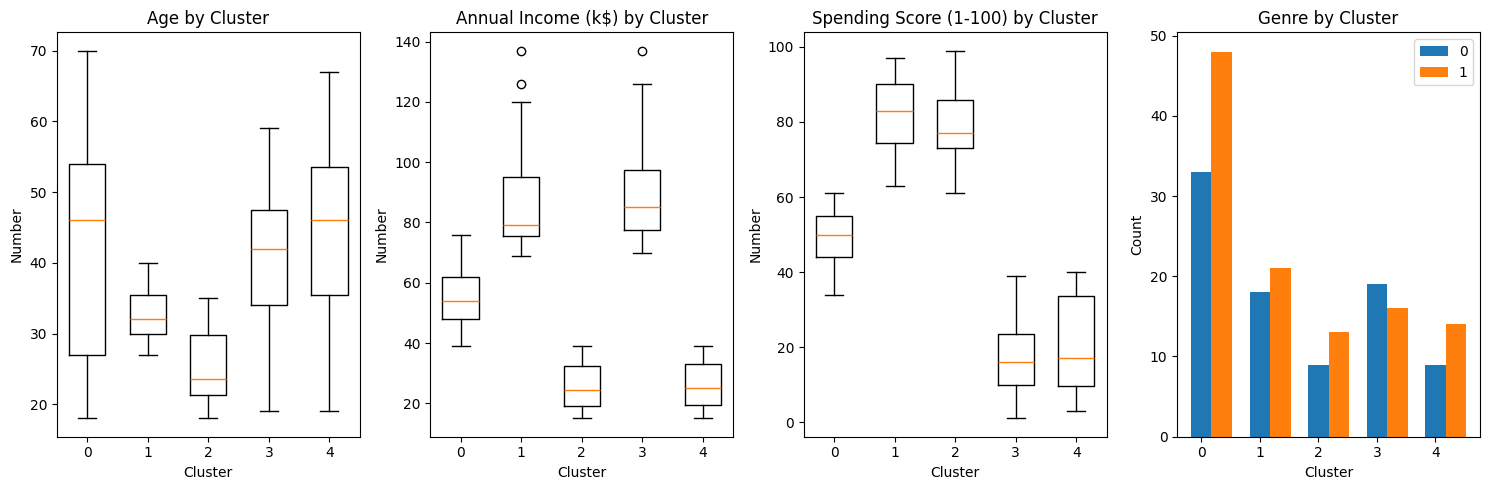

In [99]:
# Visualize feature comparsion of between clusters of best clustering results of K-Means
numeric_feature_set = ["Age", "Annual Income (k$)", "Spending Score (1-100)"]
categorial_feature_set = ["Genre"]

def plot_numerical_box(df : pd.DataFrame, feature_name : str, labels : np.ndarray, print_res : bool = False) :
	num_clusters = len(set(labels))
	data = df[feature_name].to_numpy()
	for k in range(num_clusters) :
		mask = labels == k
		cluster_data = data[mask]
		mean_value = np.mean(cluster_data)
		std_value = np.std(cluster_data)
		plt.boxplot(cluster_data, positions=[k], widths=0.6)
	plt.xlabel("Cluster")
	plt.ylabel('Number')
	plt.title(f"{feature_name} by Cluster")

	if not print_res :
		return

	# print mean and std for each cluster
	for k in range(num_clusters) :
		mask = labels == k
		cluster_data = data[mask]
		mean_value = np.mean(cluster_data)
		std_value = np.std(cluster_data)
		print(f"Cluster {k}: {feature_name} mean:{mean_value:.2f}, std:{std_value:.2f}, hq:{np.quantile(cluster_data, 0.75):.2f}, lq:{np.quantile(cluster_data, 0.25):.2f}, median:{np.median(cluster_data):.2f}")

def plot_categorial_bar(df : pd.DataFrame, feature_name : str, labels : np.ndarray, print_res : bool = False) :
	num_clusters = len(set(labels))
	categories = df[feature_name].unique()
	category_indices = {cat: i for i, cat in enumerate(categories)}
	counts = np.zeros((num_clusters, len(categories)))
	data = df[feature_name].to_numpy()
	for k in range(num_clusters) :
		mask = labels == k
		cluster_data = data[mask]
		for val in cluster_data :
			counts[k, category_indices[val]] += 1
	# plot
	bar_width = 0.35
	x = np.arange(num_clusters)
	for i, cat in enumerate(categories) :
		plt.bar(x + i * bar_width, counts[:, i], width=bar_width, label=str(cat))
	plt.xlabel("Cluster")
	plt.ylabel("Count")
	plt.title(f"{feature_name} by Cluster")
	plt.legend()

	if not print_res :
		return
	
	# print counts for each cluster
	for k in range(num_clusters) :
		print(f"Cluster {k}:")
		for i, cat in enumerate(categories) :
			print(f"  {feature_name} = {cat}: count = {counts[k, i]}")

plt.figure(figsize=(15, 5))
for i, feature in enumerate(numeric_feature_set) :
	plt.subplot(1, len(numeric_feature_set) + len(categorial_feature_set), i + 1)
	plot_numerical_box(df, feature, labels_kmeans)
for j, feature in enumerate(categorial_feature_set) :
	plt.subplot(1, len(numeric_feature_set) + len(categorial_feature_set), len(numeric_feature_set) + j + 1)
	plot_categorial_bar(df, feature, labels_kmeans)
plt.tight_layout()
plt.show()

# Analysis from ChatGPT

下面把每一类按**年龄 / 年收入（k$）/ 消费评分（1–100）/ 性别占比**做定性描述和解读（数值为图上大致区间估计，便于理解）：

**Cluster 0（中年、温和消费）**

* 年龄：中位数约 40–50 岁，分布较宽（从 ~18 到 ~70 都有）。
* 年收入：中等（大约 45–65 k$）。
* 消费评分：中等（中位数约 45–55）。
* 性别：女性略多于男性（女性占比高）。
* 解读：典型的成熟顾客群，收入与消费都处于中等水平，较稳定的消费习惯。

**Cluster 1（高收入、高消费）**

* 年龄：偏年轻到中年（约 27–40 岁）。
* 年收入：高（中位数约 75–90 k$，存在若干高收入异常值）。
* 消费评分：很高（中位数约 80–90）。
* 性别：女性略多。
* 解读：高购买力且愿意消费的顾客，适合推广高端 / 时尚 / 新品类产品。

**Cluster 2（年轻、低收入但消费偏高）**

* 年龄：很年轻（20–30 岁，偏早二十岁）。
* 年收入：低（约 15–35 k$）。
* 消费评分：偏高（中位数 ~70–80）。
* 性别：女性占多数。
* 解读：年轻、可支配收入有限但消费意愿强（可能受趋势/社交影响），适合促销、分期、低价潮流单品。

**Cluster 3（高收入、低消费）**

* 年龄：中年偏上（大约 35–50 岁）。
* 年收入：高（中位数 ~80–100 k$，也有高值）。
* 消费评分：低（中位数 ~10–20）。
* 性别：男性略多。
* 解读：有较强购买力但消费意愿/频次低（可能理性/保守或对当前品类不感兴趣），适合做唤醒、定制化与信任建立类营销。

**Cluster 4（年纪偏大、收入偏低/中等、消费分散）**

* 年龄：偏大（中位数约 40–55 岁）。
* 年收入：偏低到中等（约 15–35 k$）。
* 消费评分：偏低但分布宽（有一部分人消费到中等水平）。
* 性别：女性多于男性。
* 解读：年纪偏长、购买力有限，消费表现分化，适合价格敏感型商品或实用型服务。